In [1]:
import numpy as np 
from numpy import inf
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from math import sqrt
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.utils.data as utils
import time


In [2]:
SP=pd.read_csv('portfolio_equities.csv',delimiter=',',index_col='date')
SP_montly=pd.read_csv('portfolio_equities_monthly.csv',delimiter=',',index_col='date')
SP

,PERMNO,TICKER,COMNAM,PRC
date,,,,
12/31/1986,10333,XOMA,XOMA CORP,11.875
01/02/1987,10333,XOMA,XOMA CORP,12.250
01/05/1987,10333,XOMA,XOMA CORP,12.250
01/06/1987,10333,XOMA,XOMA CORP,12.000
01/07/1987,10333,XOMA,XOMA CORP,12.500
01/08/1987,10333,XOMA,XOMA CORP,12.500
01/09/1987,10333,XOMA,XOMA CORP,14.750
01/12/1987,10333,XOMA,XOMA CORP,15.750
01/13/1987,10333,XOMA,XOMA CORP,15.500


In [3]:
def get_equities_data(SP,permno):
    matrix = SP.loc[lambda SP: SP['PERMNO'] == permno]
    return abs(matrix['PRC'])

SP.dropna(inplace=True)
SP_montly.dropna(inplace=True)

permnos = SP_montly.drop_duplicates('PERMNO')
permnos = permnos['PERMNO'].values
tickers = SP_montly.drop_duplicates('TICKER')
tickers = tickers['TICKER'].values
    
print(permnos)
print(tickers)

[10333 12490 14593 17778 43449 48725 55976]
['XOMA' 'IBM' 'AAPL' 'BKHT' 'BRK' 'MCD' 'UNP' 'WMT']


In [4]:
matrix_daily = SP.loc[lambda SP: SP['PERMNO'] == permnos[0]]
index_daily = matrix_daily.index

matrix_monthly = SP_montly.loc[lambda SP_montly: SP_montly['PERMNO'] == permnos[0]]
index_monthly = matrix_monthly.index

columns = ['XOMA','IBM','AAPL','BRK','MCD','UNP','WMT']

df_daily = pd.DataFrame(index=index_daily, columns=columns)
df_daily = df_daily.fillna(0)

df_monthly = pd.DataFrame(index=index_monthly, columns=columns)
df_monthly = df_monthly.fillna(0)

def equity_to_df(SP, perm, df, columns):
    for i in range(len(columns)):
        df[columns[i]]= get_equities_data(SP, perm[i])
    return df

df_daily = equity_to_df(SP, permnos,df_daily ,columns)

df_monthly = equity_to_df(SP_montly, permnos, df_monthly, columns)

df_daily.fillna(value=0, inplace=True)
print(df_daily.isna().sum())
print(df_daily.min()) # the zero of BRK is dangerous to calculate its return need to change it by the median

df_daily['BRK'][df_daily['BRK'] == 0] = df_daily['BRK'].median()
print(df_daily.min())

XOMA    0
IBM     0
AAPL    0
BRK     0
MCD     0
UNP     0
WMT     0
dtype: int64
XOMA     0.2590
IBM     41.0000
AAPL    12.9375
BRK      0.0000
MCD     12.3800
UNP     33.6200
WMT     19.2500
dtype: float64
XOMA       0.2590
IBM       41.0000
AAPL      12.9375
BRK     2675.0000
MCD       12.3800
UNP       33.6200
WMT       19.2500
dtype: float64


In [5]:
ret_daily= df_daily.pct_change(1)
ret_daily = ret_daily.drop(ret_daily.index[[0]])

ret_monthly= df_monthly.pct_change(1)
ret_monthly = ret_monthly.drop(ret_monthly.index[[0]])

ret_daily.max()

XOMA    16.737351
IBM      0.131636
AAPL     0.332278
BRK      3.415663
MCD      0.108602
UNP      0.096618
WMT      0.124424
dtype: float64

In [6]:

#This code loads the totalReturns.csv file, 
#which has the dates in the first column,
#the data (in index level) for the four asset classes in columns 2 to 5
#and the risk-free rate (1-month T-bill rate) in column 6. 
S=pd.read_csv('totalReturns.csv',delimiter=',',index_col='Date')
S = S.drop('Unnamed: 6',1)

#compute returns
ret= S.pct_change(1) #take one month before in order to be able to calculate the first return
ret = ret.drop('1M T-bill rate',1)
Rf = S.iloc[:,-1].shift(1)/12
Rf = Rf.drop(Rf.index[[0]])
ret = ret.drop(ret.index[[0]])


Rf = Rf.drop(Rf.index[range(12*9)])
print(Rf)

#compute portfolio weights
ret_monthly_rolling =ret_monthly.rolling(window=120,min_periods=120) 
roll_monthly_mean = ret_monthly_rolling.mean() #rolling window = 12 month * 10 years of data to define returns of each portfolios
roll_monthly_std = ret_monthly_rolling.std()
roll_monthly_cov = ret_monthly_rolling.cov()
roll_Rf = Rf.rolling(window=120,min_periods=120).mean()

print(roll_monthly_mean)

Date
1/31/1987     0.004525
2/28/1987     0.004658
3/31/1987     0.004658
4/30/1987     0.004700
5/31/1987     0.004717
6/30/1987     0.004725
7/31/1987     0.004742
8/31/1987     0.005033
9/30/1987     0.005333
10/31/1987    0.005108
11/30/1987    0.004742
12/31/1987    0.004808
1/31/1988     0.004842
2/29/1988     0.004717
3/31/1988     0.004750
4/30/1988     0.004925
5/31/1988     0.005217
6/30/1988     0.005383
7/31/1988     0.005608
8/31/1988     0.005883
9/30/1988     0.006033
10/31/1988    0.006125
11/30/1988    0.006467
12/31/1988    0.006725
1/31/1989     0.006892
2/28/1989     0.007108
3/31/1989     0.007350
4/30/1989     0.007208
5/31/1989     0.007025
6/30/1989     0.006792
                ...   
9/30/2013     0.000017
10/31/2013    0.000042
11/30/2013    0.000058
12/31/2013    0.000058
1/31/2014     0.000033
2/28/2014     0.000042
3/31/2014     0.000042
4/30/2014     0.000025
5/31/2014     0.000025
6/30/2014     0.000033
7/31/2014     0.000025
8/31/2014     0.000025
9/30/2

In [7]:
ONES = np.ones(7)

dates = ret_monthly.iloc[119:].index.get_level_values(0)
Rf.index = ret_monthly.index
print(len(dates))

w = np.zeros((len(dates), 4, 7))
i = 0
for date in dates: 
    # esimation of parameters
    MU = roll_monthly_mean.loc[date].values
    STD = roll_monthly_std.loc[date].values
    SIGMA = roll_monthly_cov.loc[date].values
    INV_SIGMA = np.linalg.inv(SIGMA)
    #R0 = roll_Rf.loc[date]
    #i.e., estimation of risk premium (mu-R0)
    #An alternative is to esimate the expected return mu,
    #and to use the current risk-free rate to compute the weights.
    #In this second case, set: 
    R0 = Rf.loc[date]
    
    A = (ONES@INV_SIGMA)@ONES
    B = (ONES@INV_SIGMA)@MU
    C = (MU@INV_SIGMA)@MU
    DELTA = A*C-B**2
    
    # composition of portfolio
    w[i,0,:] = (INV_SIGMA@(MU-R0))/(B-A*R0) #TAN
    w[i,1,:] = (INV_SIGMA@ONES)/A # GMV
    tmp = 1/STD
    w[i,2,:] = tmp/tmp.sum() #RP
    w[i,3,:] = np.ones(7)/7 #EW
    i+=1
    

231



 (a) Time series of the portfolio weights:


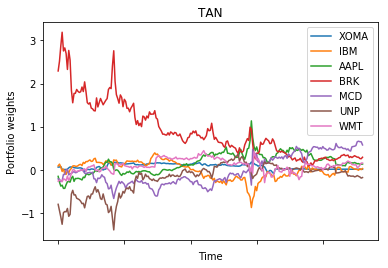

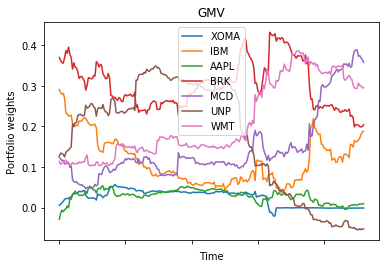

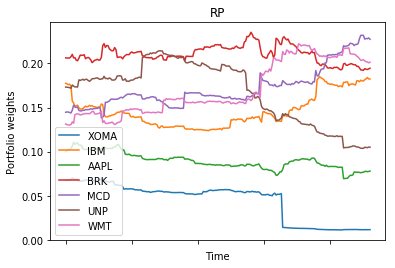

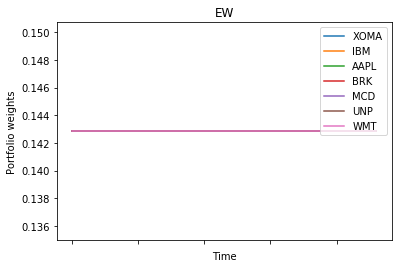

In [8]:
#plotting portfolios
asset_classes = columns
strategies = ['TAN','GMV','RP','EW']

print('\n (a) Time series of the portfolio weights:')
for i in range(len(strategies)): 
    df_w = pd.DataFrame(data=w[:,i,:],index=dates,columns=asset_classes)
    df_w.plot(title=strategies[i])
    plt.xlabel('Time')
    plt.ylabel('Portfolio weights')
    plt.legend(asset_classes, loc=0)
    plt.show()

In [9]:
#computing portfolio returns
dates_perf = ret_monthly.iloc[120:].index.get_level_values(0)

p_perf = np.zeros((len(dates_perf), 4))
for j in range(len(strategies)): 
    tmp = np.multiply(w[:-1,j,:],ret_monthly.iloc[120:]) # :-1 means except the last
    p_perf[:,j] = tmp.sum(axis=1) # sum over each lines of the matrix and p_perf = returns on each portfolios [return port for each time, strategies]
    
df_p_perf = pd.DataFrame(data=p_perf,index=dates_perf,columns=strategies)

R0 = Rf.loc[dates_perf].mean()
M = df_p_perf.mean()
E = df_p_perf.mean()-R0
S = df_p_perf.std()
SR = E/S
index = ['Mean Return', 'Mean Excess Return', 'Std. Dev.', 'Sharpe Ratio']
pStats = pd.DataFrame({index[0] : M, 
                    index[1] : E,
                    index[2] : S, 
                    index[3] : SR
                      })
pStats = pStats.T
pStats = pStats.reindex(index)

index_a = [' (ann.)']*4
index_a = [x+y for x, y in zip(index, index_a)]
pStats_a = pd.DataFrame({index_a[0] : M*12,
                    index_a[1] : E*12,
                    index_a[2] : S*np.sqrt(12),
                    index_a[3] : SR*np.sqrt(12)
                      })
pStats_a = pStats_a.T
pStats_a = pStats_a.reindex(index_a)

print('\n (b) Mean, standard deviation and Sharpe ratio of portfolio returns:')
print('\n The monthly return statistics of the strategies are:')
display(np.around(pStats,6))
print('\n The annualized return statistics of the strategies are:')
display(np.around(pStats_a,6))


 (b) Mean, standard deviation and Sharpe ratio of portfolio returns:

 The monthly return statistics of the strategies are:


,TAN,GMV,RP,EW
Mean Return,0.005595,0.006764,0.010065,0.014915
Mean Excess Return,0.003775,0.004943,0.008245,0.013095
Std. Dev.,0.109831,0.045772,0.053921,0.100922
Sharpe Ratio,0.034369,0.107995,0.152907,0.129751



 The annualized return statistics of the strategies are:


,TAN,GMV,RP,EW
Mean Return (ann.),0.067143,0.081164,0.120784,0.178982
Mean Excess Return (ann.),0.045297,0.059318,0.098939,0.157136
Std. Dev. (ann.),0.380466,0.158559,0.186788,0.349603
Sharpe Ratio (ann.),0.119058,0.374107,0.529684,0.449470



 (d) Minimum-variance frontier and location of the 4 portfolios using ex-post performance:


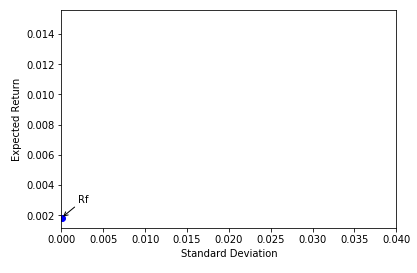

In [10]:
#MV frontiers
Mup = np.linspace(0.003,0.009,1000)
MU = ret_monthly.loc[dates_perf].mean().values
SIGMA = ret_monthly.loc[dates_perf].cov().values
INV_SIGMA = np.linalg.inv(SIGMA)


A = (ONES@INV_SIGMA)@ONES
B = (ONES@INV_SIGMA)@MU
C = (MU@INV_SIGMA)@MU
DELTA = A*C-B**2

Sigmap = np.sqrt((A*np.multiply(Mup,Mup)-2*B*Mup+C)/DELTA)

plt.plot(Sigmap,Mup)
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.plot(S,M,'ro')
plt.plot(0.0001,R0,'bo')
plt.xlim(0, 0.04)


plt.annotate('TAN', xy=(S[0],M[0]), xytext=(S[0]-.003, M[0]-.0015),
            arrowprops=dict(arrowstyle="->")
            )
plt.annotate('GMV', xy=(S[1],M[1]), xytext=(S[1]-.003, M[1]-.0015),
            arrowprops=dict(arrowstyle="->")
            )
plt.annotate('RP', xy=(S[2],M[2]), xytext=(S[2]-.003, M[2]+.0015),
            arrowprops=dict(arrowstyle="->")
            )
plt.annotate('EW', xy=(S[3],M[3]), xytext=(S[3]-.003, M[3]+.0015),
            arrowprops=dict(arrowstyle="->")
            )
plt.annotate('Rf', xy=(0, R0), xytext=(.001+.001, R0+.001),
            arrowprops=dict(arrowstyle="->")          
            )

print('\n (d) Minimum-variance frontier and location of the 4 portfolios using ex-post performance:')
plt.show()


 (e) Cumulative performance of 1$ invested in December 1987:


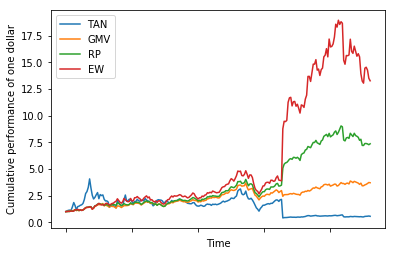

In [11]:
#total return index
dates_cumperf = ret_monthly.iloc[119:].index.get_level_values(0)
ones = np.ones((1,4))

cumperf = np.cumprod(np.concatenate((ones,1 + p_perf),axis=0),axis=0) #cumprod because when we win money we reinvest it directly
df_cumperf = pd.DataFrame(data=cumperf,index=dates_cumperf,columns=strategies)

df_cumperf.plot()
plt.xlabel('Time')
plt.ylabel('Cumulative performance of one dollar')
plt.legend(strategies, loc=0)


print('\n (e) Cumulative performance of 1$ invested in December 1987:')
plt.show()


In [12]:

labels = np.zeros(len(p_perf))
for i in range(len(p_perf)): # the goal is to define the classification of the labels for the crossentropy loss
    opt = np.argmax(p_perf[i,:])
    labels[i] = opt
print(labels.shape)
print(labels)

(230,)
[ 0.  0.  0.  1.  0.  0.  3.  3.  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.
  2.  1.  3.  3.  0.  0.  3.  0.  1.  1.  3.  3.  3.  2.  2.  0.  3.  0.
  3.  3.  0.  1.  1.  0.  3.  0.  0.  1.  0.  0.  3.  1.  3.  3.  1.  0.
  1.  0.  0.  1.  3.  0.  3.  1.  3.  0.  1.  1.  0.  0.  0.  3.  2.  0.
  0.  3.  0.  3.  3.  2.  3.  0.  2.  1.  0.  1.  0.  2.  2.  0.  3.  3.
  2.  1.  2.  3.  3.  3.  0.  1.  1.  0.  3.  0.  3.  2.  3.  0.  3.  1.
  1.  1.  0.  2.  0.  1.  0.  0.  3.  3.  0.  1.  3.  0.  0.  3.  0.  0.
  1.  0.  3.  0.  0.  0.  1.  1.  3.  0.  3.  2.  3.  0.  1.  0.  1.  2.
  3.  2.  0.  0.  0.  3.  3.  0.  0.  1.  3.  2.  0.  0.  3.  3.  0.  0.
  1.  3.  3.  2.  0.  3.  3.  0.  2.  3.  3.  2.  0.  0.  0.  2.  1.  0.
  3.  0.  3.  3.  1.  3.  3.  0.  1.  1.  3.  2.  1.  2.  3.  0.  3.  1.
  3.  0.  1.  0.  3.  3.  3.  3.  1.  0.  0.  1.  2.  3.  1.  3.  3.  1.
  3.  0.  0.  2.  3.  3.  1.  0.  1.  3.  0.  1.  0.  2.]


In [13]:
fama_daily = pd.read_csv('fama_french.csv',delimiter=',')
rf_daily = fama_daily['RF']

dates = fama_daily['date']
dates = pd.to_datetime(dates,format='%Y%m%d').dt.strftime('%m/%d/%Y')

rf_daily.index = dates

target_dates = ret_daily.index

Rf_fama = rf_daily.loc[target_dates]

print(Rf_fama.shape, df_daily.shape)
print(Rf_fama)

(7939,) (7940, 7)
date
01/02/1987    0.020
01/05/1987    0.020
01/06/1987    0.020
01/07/1987    0.020
01/08/1987    0.020
01/09/1987    0.020
01/12/1987    0.020
01/13/1987    0.020
01/14/1987    0.020
01/15/1987    0.020
01/16/1987    0.020
01/19/1987    0.020
01/20/1987    0.020
01/21/1987    0.020
01/22/1987    0.020
01/23/1987    0.020
01/26/1987    0.020
01/27/1987    0.020
01/28/1987    0.020
01/29/1987    0.020
01/30/1987    0.020
02/02/1987    0.023
02/03/1987    0.023
02/04/1987    0.023
02/05/1987    0.023
02/06/1987    0.023
02/09/1987    0.023
02/10/1987    0.023
02/11/1987    0.023
02/12/1987    0.023
              ...  
05/18/2018    0.006
05/21/2018    0.006
05/22/2018    0.006
05/23/2018    0.006
05/24/2018    0.006
05/25/2018    0.006
05/29/2018    0.006
05/30/2018    0.006
05/31/2018    0.006
06/01/2018    0.006
06/04/2018    0.006
06/05/2018    0.006
06/06/2018    0.006
06/07/2018    0.006
06/08/2018    0.006
06/11/2018    0.006
06/12/2018    0.006
06/13/2018    0.0

In [14]:
print(max(Rf_fama))
print(min(Rf_fama))

0.036000000000000004
0.0


In [248]:
def dailytosomething(df,rf,number):
    new_df = df.iloc[::number,:]
    new_rf = rf.iloc[::number]
    new_rf = new_rf.iloc[:].shift(1)#/12
    ret= new_df.pct_change(1)
    ret = ret.drop(ret.index[[0]])
    rf_final = new_rf.drop(new_rf.index[[0]])
    return ret,rf_final

number = 5
ret_weekly, Rf_weekly = dailytosomething(df_daily,Rf_fama,number)
print(ret_weekly.shape)
print(Rf_weekly.shape)

Rf_weekly = ((1 + Rf_weekly)**number) -1


print(ret_weekly.iloc[0])
print(ret_daily.iloc[:5])

(1587, 7)
(1587,)
XOMA    0.052632
IBM     0.023958
AAPL    0.104938
BRK     0.060284
MCD     0.065708
UNP     0.042169
WMT     0.029570
Name: 01/08/1987, dtype: float64
                XOMA       IBM      AAPL       BRK       MCD       UNP  \
date                                                                     
01/02/1987  0.031579  0.016667  0.009259  0.033688  0.018480  0.016064   
01/05/1987  0.000000  0.013320  0.051988  0.018868  0.040323  0.043478   
01/06/1987 -0.020408 -0.005056  0.017442  0.013468  0.003876 -0.003788   
01/07/1987  0.041667  0.004065  0.022857  0.001661 -0.001931 -0.003802   
01/08/1987  0.000000 -0.005061  0.000000 -0.008292  0.003868 -0.009542   

                 WMT  
date                  
01/02/1987  0.005376  
01/05/1987  0.024064  
01/06/1987  0.018277  
01/07/1987 -0.010256  
01/08/1987 -0.007772  


In [249]:
#compute portfolio weights
rolling_window_step = 300

roll_weekly_mean = ret_weekly.rolling(window=rolling_window_step,min_periods=rolling_window_step).mean() #rolling window = 12 month * 10 years of data to define returns of each portfolios
roll_weekly_std = ret_weekly.rolling(window=rolling_window_step,min_periods=rolling_window_step).std()
roll_weekly_cov = ret_weekly.rolling(window=rolling_window_step,min_periods=rolling_window_step).cov()
roll_weekly_Rf = Rf_weekly.rolling(window=rolling_window_step,min_periods=rolling_window_step).mean()


1288

 (a) Time series of the portfolio weights:


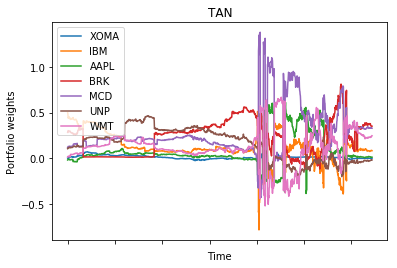

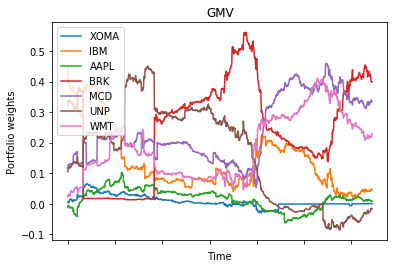

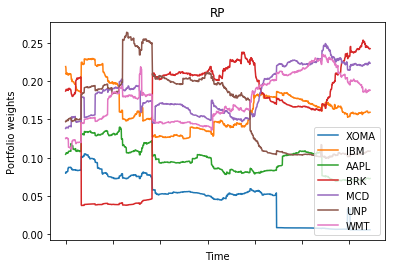

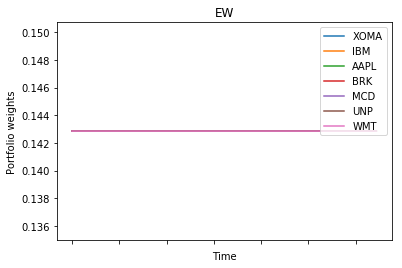

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


In [250]:
ONES = np.ones(7)

dates = ret_weekly.iloc[(rolling_window_step-1):].index.get_level_values(0)
print(len(dates))
Rf_weekly.index = ret_weekly.index

w = np.zeros((len(dates), 4, 7))
i = 0
for date in dates: 
    # esimation of parameters
    MU = roll_weekly_mean.loc[date].values
    STD = roll_weekly_std.loc[date].values
    SIGMA = roll_weekly_cov.loc[date].values
    INV_SIGMA = np.linalg.inv(SIGMA)
    #R0 = roll_Rf.loc[date]
    #i.e., estimation of risk premium (mu-R0)
    #An alternative is to esimate the expected return mu,
    #and to use the current risk-free rate to compute the weights.
    #In this second case, set: 
    R0 = Rf_weekly.loc[date]
    
    A = (ONES@INV_SIGMA)@ONES
    B = (ONES@INV_SIGMA)@MU
    C = (MU@INV_SIGMA)@MU
    DELTA = A*C-B**2
    
    # composition of portfolio
    w[i,0,:] = (INV_SIGMA@(MU-R0))/(B-A*R0) #TAN
    w[i,1,:] = (INV_SIGMA@ONES)/A # GMV
    tmp = 1/STD
    w[i,2,:] = tmp/tmp.sum() #RP
    w[i,3,:] = np.ones(7)/7 #EW
    i+=1
    

#plotting portfolios
asset_classes = columns
strategies = ['TAN','GMV','RP','EW']

print('\n (a) Time series of the portfolio weights:')
for i in range(len(strategies)): 
    df_w = pd.DataFrame(data=w[:,i,:],index=dates,columns=asset_classes)
    df_w.plot(title=strategies[i])
    plt.xlabel('Time')
    plt.ylabel('Portfolio weights')
    plt.legend(asset_classes, loc=0)
    plt.show()
print(sum(np.isnan(w)))

In [251]:
#computing portfolio returns
dates_perf = ret_weekly.iloc[rolling_window_step:].index.get_level_values(0)

p_perf = np.zeros((len(dates_perf), 4))
for j in range(len(strategies)): 
    tmp = np.multiply(w[:-1,j,:],ret_weekly.iloc[rolling_window_step:]) # :-1 means except the last
    p_perf[:,j] = tmp.sum(axis=1) # sum over each lines of the matrix and p_perf = returns on each portfolios [return port for each time, strategies]
    
df_p_perf = pd.DataFrame(data=p_perf,index=dates_perf,columns=strategies)

R0 = Rf_weekly.loc[dates_perf].mean()
M = df_p_perf.mean()
E = df_p_perf.mean()-R0
S = df_p_perf.std()
SR = E/S
index = ['Mean Return', 'Mean Excess Return', 'Std. Dev.', 'Sharpe Ratio']
pStats = pd.DataFrame({index[0] : M, 
                    index[1] : E,
                    index[2] : S, 
                    index[3] : SR
                      })
pStats = pStats.T
pStats = pStats.reindex(index)

index_a = [' (ann.)']*4
index_a = [x+y for x, y in zip(index, index_a)]
pStats_a = pd.DataFrame({index_a[0] : M*12, # change *12 cause were not anymore annual
                    index_a[1] : E*12,  # change *12 cause were not anymore annual
                    index_a[2] : S*np.sqrt(12),  # change *12 cause were not anymore annual
                    index_a[3] : SR*np.sqrt(12)  # change *12 cause were not anymore annual
                      })
pStats_a = pStats_a.T
pStats_a = pStats_a.reindex(index_a)

print('\n (b) Mean, standard deviation and Sharpe ratio of portfolio returns:')
print('\n The monthly return statistics of the strategies are:')
display(np.around(pStats,6))
print('\n The annualized return statistics of the strategies are:')
display(np.around(pStats_a,6))




 (b) Mean, standard deviation and Sharpe ratio of portfolio returns:

 The monthly return statistics of the strategies are:


,TAN,GMV,RP,EW
Mean Return,0.002738,0.002603,0.003358,0.005451
Mean Excess Return,-0.046305,-0.046440,-0.045685,-0.043592
Std. Dev.,0.042133,0.042033,0.037064,0.076137
Sharpe Ratio,-1.099009,-1.104857,-1.232578,-0.572541



 The annualized return statistics of the strategies are:


,TAN,GMV,RP,EW
Mean Return (ann.),0.032854,0.031234,0.040297,0.065416
Mean Excess Return (ann.),-0.555661,-0.557280,-0.548218,-0.523099
Std. Dev. (ann.),0.145955,0.145605,0.128395,0.263747
Sharpe Ratio (ann.),-3.807079,-3.827336,-4.269776,-1.983338



 (d) Minimum-variance frontier and location of the 4 portfolios using ex-post performance:


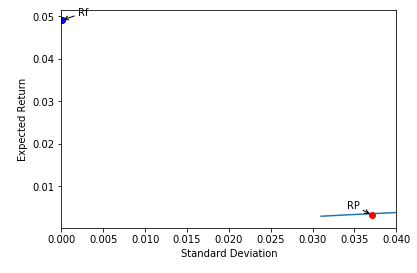

In [252]:
#MV frontiers
Mup = np.linspace(0.003,0.009,1000)
MU = ret_weekly.loc[dates_perf].mean().values
SIGMA = ret_weekly.loc[dates_perf].cov().values
INV_SIGMA = np.linalg.inv(SIGMA)


A = (ONES@INV_SIGMA)@ONES
B = (ONES@INV_SIGMA)@MU
C = (MU@INV_SIGMA)@MU
DELTA = A*C-B**2

Sigmap = np.sqrt((A*np.multiply(Mup,Mup)-2*B*Mup+C)/DELTA)

plt.plot(Sigmap,Mup)
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.plot(S,M,'ro')
plt.plot(0.0001,R0,'bo')
plt.xlim(0, 0.04)


plt.annotate('TAN', xy=(S[0],M[0]), xytext=(S[0]-.003, M[0]-.0015),
            arrowprops=dict(arrowstyle="->")
            )
plt.annotate('GMV', xy=(S[1],M[1]), xytext=(S[1]-.003, M[1]-.0015),
            arrowprops=dict(arrowstyle="->")
            )
plt.annotate('RP', xy=(S[2],M[2]), xytext=(S[2]-.003, M[2]+.0015),
            arrowprops=dict(arrowstyle="->")
            )
plt.annotate('EW', xy=(S[3],M[3]), xytext=(S[3]-.003, M[3]+.0015),
            arrowprops=dict(arrowstyle="->")
            )
plt.annotate('Rf', xy=(0, R0), xytext=(.001+.001, R0+.001),
            arrowprops=dict(arrowstyle="->")          
            )

print('\n (d) Minimum-variance frontier and location of the 4 portfolios using ex-post performance:')
plt.show()





 (e) Cumulative performance of 1$ invested in December 1987:


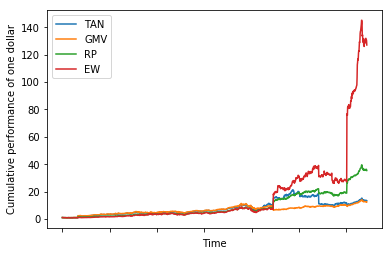

In [253]:
#total return index
dates_cumperf = ret_weekly.iloc[(rolling_window_step-1):].index.get_level_values(0)
ones = np.ones((1,4))

cumperf = np.cumprod(np.concatenate((ones,1 + p_perf),axis=0),axis=0) #cumprod because when we win money we reinvest it directly
df_cumperf = pd.DataFrame(data=cumperf,index=dates_cumperf,columns=strategies)

#df_cumperf.drop(columns=['TAN'],inplace=True)
df_cumperf.plot()
plt.xlabel('Time')
plt.ylabel('Cumulative performance of one dollar')
strategies = ['TAN','GMV','RP','EW']
#strategies = ['GMV','RP','EW']
plt.legend(strategies, loc=0)
#plt.ylim([-20,50])


print('\n (e) Cumulative performance of 1$ invested in December 1987:')
plt.show()


In [254]:
labels = np.zeros(len(p_perf))
for i in range(len(p_perf)): # the goal is to define the classification of the labels for the crossentropy loss
    opt = np.argmax(p_perf[i,:])
    labels[i] = opt
print(labels.shape)
print(labels)

labels_training = labels[:1012]
labels_test = labels[1012:]

print(labels_training.shape[0] + labels_test.shape[0])

(1287,)
[ 3.  3.  0. ...,  1.  3.  0.]
1287


In [255]:
print(sum(labels_training == 0))
print(sum(labels_training == 1))
print(sum(labels_training == 2))
print(sum(labels_training == 3))

print(sum(labels_test == 0))
print(sum(labels_test == 1))
print(sum(labels_test == 2))
print(sum(labels_test == 3))

# starting date of labels : 10/17/1989 because we need five days of inputs in order to predict
# the best portfolio in 6 days
print(roll_weekly_mean.iloc[rolling_window_step])

#starting date of our inputs : 09/27/1989
print(roll_weekly_mean.iloc[rolling_window_step-2])

#last date of labels : 06/28/2018
#print(ret_weekly.iloc[-1])

indexes = roll_weekly_mean.iloc[rolling_window_step-2:].index
index = indexes[0]
index

310
209
91
402
55
74
36
110
XOMA    0.003327
IBM    -0.001759
AAPL    0.003177
BRK     0.005094
MCD     0.000583
UNP     0.001036
WMT     0.002792
Name: 12/11/1992, dtype: float64
XOMA   NaN
IBM    NaN
AAPL   NaN
BRK    NaN
MCD    NaN
UNP    NaN
WMT    NaN
Name: 11/27/1992, dtype: float64


'11/27/1992'

In [256]:
def co_columns_name(columns, string):
    res =[]
    for c in columns:
        for c1 in columns:
            if c!=c1:
                res.append(string+c+"_"+c1)
    return res

def get_co_matrix(co_rolling, columns, co_columns, dates):  
    data = pd.DataFrame(columns = co_columns)
    count = 0
    for tick in columns:
        i = 0
        for tick2 in columns:
            if tick!=tick2:
                data[co_columns[count]] = co_rolling[tick][i::7].values
                count+=1
            i+=1
    return data.set_index(dates)
def include_co_in_input(inputs, co_data):
    for c in co_data.columns:
        inputs[c] = co_data[c]
    return inputs
corr_columns =co_columns_name(columns, "corr_")
print(corr_columns)
#print(corr_columns[5], corr_rolling["XOMA"][3::7])
cov_columns = co_columns_name(columns, "cov_")

['corr_XOMA_IBM', 'corr_XOMA_AAPL', 'corr_XOMA_BRK', 'corr_XOMA_MCD', 'corr_XOMA_UNP', 'corr_XOMA_WMT', 'corr_IBM_XOMA', 'corr_IBM_AAPL', 'corr_IBM_BRK', 'corr_IBM_MCD', 'corr_IBM_UNP', 'corr_IBM_WMT', 'corr_AAPL_XOMA', 'corr_AAPL_IBM', 'corr_AAPL_BRK', 'corr_AAPL_MCD', 'corr_AAPL_UNP', 'corr_AAPL_WMT', 'corr_BRK_XOMA', 'corr_BRK_IBM', 'corr_BRK_AAPL', 'corr_BRK_MCD', 'corr_BRK_UNP', 'corr_BRK_WMT', 'corr_MCD_XOMA', 'corr_MCD_IBM', 'corr_MCD_AAPL', 'corr_MCD_BRK', 'corr_MCD_UNP', 'corr_MCD_WMT', 'corr_UNP_XOMA', 'corr_UNP_IBM', 'corr_UNP_AAPL', 'corr_UNP_BRK', 'corr_UNP_MCD', 'corr_UNP_WMT', 'corr_WMT_XOMA', 'corr_WMT_IBM', 'corr_WMT_AAPL', 'corr_WMT_BRK', 'corr_WMT_MCD', 'corr_WMT_UNP']


In [257]:
ret_daily_input = ret_daily.loc[index:]
ret_daily_input

,XOMA,IBM,AAPL,BRK,MCD,UNP,WMT
date,,,,,,,
11/27/1992,-0.025641,0.009560,0.000000,-0.013699,0.018182,0.008421,0.009862
11/30/1992,0.052632,0.034091,0.017699,-0.006944,0.000000,0.006263,0.005859
12/01/1992,-0.050000,-0.007326,0.013043,-0.023310,0.000000,-0.018672,-0.003883
12/02/1992,0.052632,0.001845,-0.017167,0.007160,0.000000,-0.012685,0.003899
12/03/1992,0.175000,-0.009208,0.004367,0.009479,0.000000,0.010707,-0.017476
12/04/1992,-0.021277,-0.003717,-0.010870,0.018779,-0.002551,0.004237,0.009881
12/07/1992,0.043478,-0.016791,0.015385,0.036866,0.005115,0.004219,0.007828
12/08/1992,0.041667,-0.007590,0.006494,-0.004444,0.010178,-0.012605,0.000000
12/09/1992,-0.020000,-0.042065,-0.008602,0.013393,-0.012594,0.012766,0.000000


In [258]:
N_LABELS =64
N_ASSETS =7
start_index= np.where(df_daily.index==index)[0]-rolling_window_step#596
start_index = start_index[0]
print(start_index)
rolling_window_step_daily = rolling_window_step 

ret_daily_rolling =  ret_daily.rolling(window=rolling_window_step_daily,min_periods=rolling_window_step_daily)

roll_daily_mean = ret_daily_rolling.mean()
roll_daily_std = ret_daily_rolling.std()
roll_Rf_daily_mean = Rf_fama.rolling(window=rolling_window_step_daily,min_periods=rolling_window_step_daily).mean()


def column_names(tickers,original =False, mean= False, std=False):
    res = []
    for t in tickers: 
        if original:
            res.append(t)
        if mean:
            res.append(t+"_mean")
        if std:
            res.append(t+"_std")
    return res

dates = ret_daily.loc[index:].index.get_level_values(0)
print(dates)
input_price = pd.DataFrame(ret_daily.loc[index:].values,columns=columns).set_index(dates)
input_mean = pd.DataFrame(roll_daily_mean.loc[index:].values,columns=column_names(columns, mean= True)).set_index(dates)
input_std = pd.DataFrame(roll_daily_std.loc[index:].values,columns=column_names(columns, std=True)).set_index(dates)

concat = pd.concat([input_price, input_mean, input_std], axis=1)
inputs = concat[column_names(columns, True, True, True)][:-number] #can not predict the last horizon
inputs['Rf'] = roll_Rf_daily_mean.loc[index:]
correlation_rolling = ret_daily_rolling.corr().dropna()[start_index*N_ASSETS:-number*N_ASSETS]
print(start_index)
#co[start_index*7:-number*7]
#correlation_data = get_co_matrix(correlation_rolling,columns, corr_columns,dates[:-number])
cov_rolling = ret_daily_rolling.cov().dropna()[start_index*N_ASSETS:-number*N_ASSETS]

cov_data = get_co_matrix(cov_rolling, columns, cov_columns,dates[:-number])
inputs = include_co_in_input(inputs, cov_data)
#inputs = include_co_in_input(inputs, correlation_data)
print(inputs)

def reshape_inputs(inputs, number):
    if inputs.shape[0] % number == 0:
        lstm_inputs = inputs.values.reshape((int(len(inputs)/number),number,N_LABELS))
        print("dataframe original shape", inputs.shape, "reshaped to ", lstm_inputs.shape)
    else:
        flo = np.floor(inputs.shape[0]/number)
        length = (flo + 1) * number
        length = length - inputs.shape[0]
        add = pd.DataFrame(0, index=np.arange(length), columns=inputs.columns)
        new_inputs = inputs.append(add)
        lstm_inputs = new_inputs.values.reshape((int(len(new_inputs)/number),number,N_LABELS))
        print(new_inputs)
        print("dataframe original shape", inputs.shape, "reshaped to ", lstm_inputs.shape)
    
    return lstm_inputs

lstm_inputs = reshape_inputs(inputs, number)


1195
Index(['11/27/1992', '11/30/1992', '12/01/1992', '12/02/1992', '12/03/1992',
       '12/04/1992', '12/07/1992', '12/08/1992', '12/09/1992', '12/10/1992',
       ...
       '06/18/2018', '06/19/2018', '06/20/2018', '06/21/2018', '06/22/2018',
       '06/25/2018', '06/26/2018', '06/27/2018', '06/28/2018', '06/29/2018'],
      dtype='object', name='date', length=6445)
1195
                XOMA  XOMA_mean  XOMA_std       IBM  IBM_mean   IBM_std  \
date                                                                      
11/27/1992 -0.025641  -0.001069  0.041115  0.009560 -0.001430  0.014411   
11/30/1992  0.052632  -0.000845  0.041224  0.034091 -0.001357  0.014536   
12/01/1992 -0.050000  -0.001012  0.041321 -0.007326 -0.001354  0.014534   
12/02/1992  0.052632  -0.000836  0.041437  0.001845 -0.001343  0.014536   
12/03/1992  0.175000  -0.000128  0.042608 -0.009208 -0.001291  0.014478   
12/04/1992 -0.021277  -0.000199  0.042626 -0.003717 -0.001348  0.014453   
12/07/1992  0.043478  

In [259]:
from sklearn.model_selection import train_test_split

#labels_training = labels[:1013]
#labels_test = labels[1013:]

X_train = lstm_inputs[:1012]
y_train = labels_training

X_test = lstm_inputs[1012:-1]
y_test = labels_test


#print(labels.shape,lstm_inputs.shape)
#X_train, X_test, y_train, y_test = train_test_split(lstm_inputs,labels, test_size=0.25)

print(X_train.shape, X_test.shape)
print(X_train.shape[0] + X_test.shape[0], labels.shape[0])

(1012, 5, 64) (275, 5, 64)
1287 1287


In [260]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_train = X_train.permute(1,0,2)

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()
X_test = X_test.permute(1,0,2)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([5, 1012, 64]) torch.Size([1012])
torch.Size([5, 275, 64]) torch.Size([275])


In [261]:
batch_dim = number #diviseur de valloader
traindataset = utils.TensorDataset(X_train.permute(1,0,2), y_train)
trainloader = utils.DataLoader(traindataset, batch_size=batch_dim, shuffle=True)

testdataset = utils.TensorDataset(X_test.permute(1,0,2), y_test)
testloader = utils.DataLoader(testdataset, batch_size=batch_dim, shuffle=True)

In [262]:
#let's define the lSTM network 

    
class LSTM(nn.Module):

    def __init__(self,input_size,output_size,batch_size,num_layers,hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size

        # The LSTM takes features as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(input_size, hidden_size)

        # The linear layer that maps from hidden state space to output space
        self.hidden2output = nn.Linear(hidden_size, output_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_size),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_size))

    def forward(self, input_seq):
        
        output_seq, self.hidden = self.lstm(input_seq, self.hidden)#, None)
        last_output = output_seq[-1]
        output = self.hidden2output(last_output)
        
        return output
    
    def predict(self,x):
        out = self.forward(x)
        return out
        
    

In [263]:
from torch import optim

lr = 0.000001

#weights = [1, 1, 3, 0.8]
#class_weights = torch.FloatTensor(weights)

print(X_train.shape[2])
lstm = LSTM(input_size = X_train.shape[2], output_size = 4, batch_size=batch_dim,num_layers=1,hidden_size = 250)
optimizer = optim.Adam(lstm.parameters(), lr=lr,weight_decay=1e-6)
criterion = nn.CrossEntropyLoss()#(weight=class_weights)

64


In [264]:
epochs = 50
steps = 0
print_every = 323
running_loss = 0

loss_train = []
loss_val = []
for e in range(epochs):
    start = time.time()
    
    total_train_loss=0
    steps_bis = 0
    if e % 40==0:
        lr /= 2
        optimizer = optim.Adam(lstm.parameters(), lr=lr,weight_decay=1e-6)

    for X_tr, y_tr in iter(trainloader):
        steps += 1
        steps_bis+=1
        
        # Clear stored gradient
        lstm.zero_grad()
        
        # Initialise hidden state
        # Don't do this if you want your LSTM to be stateful
        lstm.hidden = lstm.init_hidden()

        X_tr = X_tr.permute([1,0,2])
        #y_tr = y_tr.permute([1,0,2])
        
        if X_tr.shape[1] != batch_dim:
            continue

        in_train = Variable(X_tr)
        targets = Variable(y_tr).long()
        
        #optimizer.zero_grad()
        
        out = lstm.forward(in_train)
        
        loss = criterion(out, targets)
        
        loss.backward(retain_graph=True)
        optimizer.step()
        
        running_loss += loss.item()
    
        if steps % print_every == 0:
            stop = time.time()
            val_loss=0
            for ii, (X_validation, y_validation) in enumerate(testloader):
                    
                X_validation = X_validation.permute([1,0,2])
                #y_validation = y_validation.permute([1,0,2])
                    
                if X_validation.shape[1] != batch_dim:
                    continue
                    
                inputs = Variable(X_validation, volatile=True)
                predicted = lstm.predict(inputs)
                    
                val_loss+= (criterion(predicted,y_validation.long()).item())
                    
            print("Epoch: {}/{}..".format(e+1, epochs),
                "Validation loss: {:.4f}..".format(val_loss/ii),
                "Training loss: {:.4f}..".format(running_loss/print_every),
                "{:.4f} s/batch".format((stop - start)/print_every)
                )
                
            loss_val.append(val_loss/ii)
            loss_train.append(running_loss/print_every)
            running_loss = 0
            start = time.time()

/home/gregoire/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Epoch: 2/50.. Validation loss: 1.4087.. Training loss: 1.3867.. 0.0034 s/batch
Epoch: 4/50.. Validation loss: 1.4080.. Training loss: 1.3809.. 0.0013 s/batch
Epoch: 5/50.. Validation loss: 1.4074.. Training loss: 1.3849.. 0.0044 s/batch
Epoch: 7/50.. Validation loss: 1.4068.. Training loss: 1.3802.. 0.0021 s/batch
Epoch: 8/50.. Validation loss: 1.4061.. Training loss: 1.3829.. 0.0067 s/batch
Epoch: 10/50.. Validation loss: 1.4055.. Training loss: 1.3786.. 0.0043 s/batch
Epoch: 12/50.. Validation loss: 1.4049.. Training loss: 1.3772.. 0.0008 s/batch
Epoch: 13/50.. Validation loss: 1.4042.. Training loss: 1.3804.. 0.0050 s/batch
Epoch: 15/50.. Validation loss: 1.4036.. Training loss: 1.3762.. 0.0020 s/batch
Epoch: 16/50.. Validation loss: 1.4031.. Training loss: 1.3795.. 0.0062 s/batch
Epoch: 18/50.. Validation loss: 1.4024.. Training loss: 1.3746.. 0.0038 s/batch
Epoch: 20/50.. Validation loss: 1.4018.. Training loss: 1.3734.. 0.0006 s/batch
Epoch: 21/50.. Validation loss: 1.4012.. Trai

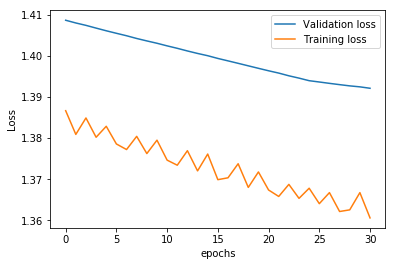

In [268]:
plt.plot(range(len(loss_val)),loss_val, label='Validation loss')
plt.plot(range(len(loss_train)),loss_train, label='Training loss')
plt.xlabel('epochs')
plt.ylabel('Loss')

plt.legend()
loss_file="Loss_for_"
name_file= str(epochs)+" epochs_"+str(number)+"batch_"+"lr_smaller"
plt.savefig(loss_file+name_file)
plt.show()


In [269]:
y_pred = np.zeros((int(len(y_test)/batch_dim),batch_dim))
print(y_pred.shape)
for ii, (x_validation,y_validation) in enumerate(testloader):
    x_validation = x_validation.permute([1,0,2])           
    inputs = Variable(x_validation)
    if inputs.shape[1]!= batch_dim:
        print(ii*batch_dim-y_test.shape[0])
        break
    pred = lstm.predict(inputs).data.numpy()
    y_pred[ii,:] = np.argmax(pred, axis=1)
    print(pred)
y_pred.shape

(55, 5)
[[-0.01765385 -0.01120296 -0.07244277  0.06815646]
 [-0.01765069 -0.01115484 -0.07252569  0.06818264]
 [-0.01625061 -0.011854   -0.07222459  0.06880591]
 [-0.01756487 -0.01098213 -0.07300752  0.06807315]
 [-0.0165367  -0.01066614 -0.07451359  0.06900118]]
[[-0.01723015 -0.01106017 -0.0731955   0.06880823]
 [-0.01775097 -0.01126458 -0.07262708  0.06835361]
 [-0.01729638 -0.01106716 -0.07272478  0.06819329]
 [-0.01798858 -0.01149506 -0.07195197  0.06795387]
 [-0.01597165 -0.01272074 -0.08555857  0.09113008]]
[[-0.01749549 -0.01107054 -0.07311243  0.06815646]
 [-0.0171013  -0.01090285 -0.0736524   0.06866   ]
 [-0.01717678 -0.01053671 -0.07362976  0.06826195]
 [-0.01717599 -0.01112062 -0.07392865  0.06933481]
 [-0.01613125 -0.0116865  -0.07220157  0.06886858]]
[[-0.01740606 -0.01075927 -0.07325596  0.06913957]
 [-0.01737143 -0.01063369 -0.07381996  0.06917177]
 [-0.01732112 -0.01105737 -0.07376971  0.06899511]
 [-0.01741532 -0.01110967 -0.0736338   0.06918243]
 [-0.017407   -0.011

(55, 5)

(276, 5)

 (e) Cumulative performance of 1$ invested in December 1987:


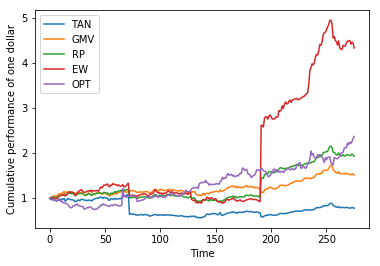

In [270]:
y_bar = np.reshape(y_pred,y_pred.shape[0]*y_pred.shape[1])

p_perf_test = p_perf[1012:]
dif = p_perf_test.shape[0] - y_bar.shape[0]

y_bar_approxi = np.append(y_bar,np.zeros(dif))

opt_portfolio = np.zeros(len(p_perf_test))
for i in range(len(p_perf_test)):
    opt_portfolio[i] = p_perf[i,int(y_bar_approxi[i])]

performance = np.c_[p_perf_test, opt_portfolio ]
strategies = ['TAN','GMV','RP','EW','OPT']

ones = np.ones((1,5))
cumperf = np.cumprod(np.concatenate((ones,1 + performance),axis=0),axis=0) #cumprod because when we win money we reinvest it directly
print(cumperf.shape)
df_cumperf = pd.DataFrame(data=cumperf,columns=strategies) #,index=dates_cumperf

df_cumperf.plot()
plt.xlabel('Time')
plt.ylabel('Cumulative performance of one dollar')
plt.legend(strategies, loc=0)
#plt.ylim([-20,50])


print('\n (e) Cumulative performance of 1$ invested in December 1987:')
plt.savefig("Cumulative_perf_of_1$"+name_file)
plt.show()